## Import packages

In [44]:
import pandas as pd
import numpy as np
import scanpy as sc
import scanpy.external as sce
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
import math
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=500, frameon=False, vector_friendly=True, fontsize=14, figsize=None, color_map=None, format='pdf', facecolor=None, transparent=True)

## Load

In [46]:
adata = sc.read('data/segmentoid_originalmatrix.h5ad')

## Pre process

In [47]:
sc.pp.filter_cells(adata, min_counts=4000)
sc.pp.filter_cells(adata, max_counts=65000)
sc.pp.filter_cells(adata, min_genes=3000)
sc.pp.filter_cells(adata, max_genes=8000)

In [48]:
cell_cycle_genes = [x.strip() for x in open('utils/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

In [49]:
adata.var["mito"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mito"], inplace=True)
adata = adata[adata.obs['pct_counts_mito'] < 10, :]

In [15]:
adata.raw = adata

In [16]:
sc.pp.normalize_total(adata)

In [17]:
sc.pp.log1p(adata)

In [18]:
sc.pp.highly_variable_genes(adata, n_top_genes=1500)

In [19]:
sc.pp.regress_out(adata, ['S_score', 'G2M_score'], n_jobs = 16)

... storing 'phase' as categorical


In [20]:
sc.pp.scale(adata)

In [21]:
sc.tl.pca(adata, n_comps=50)

In [24]:
sce.pp.bbknn(adata, batch_key='timepoint', local_connectivity=6)

In [25]:
sc.tl.umap(adata)

In [26]:
sc.tl.leiden(adata, resolution=.4)

In [27]:
adata.obs['leiden'] = adata.obs['leiden'].replace(['0'],'Somite')
adata.obs['leiden'] = adata.obs['leiden'].replace(['1'],'PSM Post')
adata.obs['leiden'] = adata.obs['leiden'].replace(['2'],'Somite')
adata.obs['leiden'] = adata.obs['leiden'].replace(['3'],'iPSC')
adata.obs['leiden'] = adata.obs['leiden'].replace(['4'],'NMP')
adata.obs['leiden'] = adata.obs['leiden'].replace(['5'],'PSM Ant')
adata.obs['leiden'] = adata.obs['leiden'].replace(['6'],'NMP/Neural')

In [4]:
sc.pl.umap(adata, color=['leiden'], title='Segmentoid', palette=['tab:red', 'tab:cyan', 'tab:gray', 'tab:green', 'tab:blue', 'tab:purple'])

NameError: name 'adata' is not defined

## NMP/NEURAL SPLIT - LEIDEN CORRECTION

In [30]:
tmp = adata[adata.obs['leiden'].isin(['NMP/Neural']),:]
adata_sc = sc.AnnData(tmp.raw.X,obs=tmp.obs,var=tmp.raw.var,uns=tmp.uns,obsm=tmp.obsm,obsp=tmp.obsp)

In [31]:
adata_sc.raw = adata_sc

In [32]:
sc.tl.umap(adata_sc)

In [33]:
sc.tl.leiden(adata_sc, resolution=.1, key_added='leiden_sc')

In [34]:
adata_sc.obs['leiden_sc'] = adata_sc.obs['leiden_sc'].replace(['0'],'NMP')
adata_sc.obs['leiden_sc'] = adata_sc.obs['leiden_sc'].replace(['1'],'Neural')

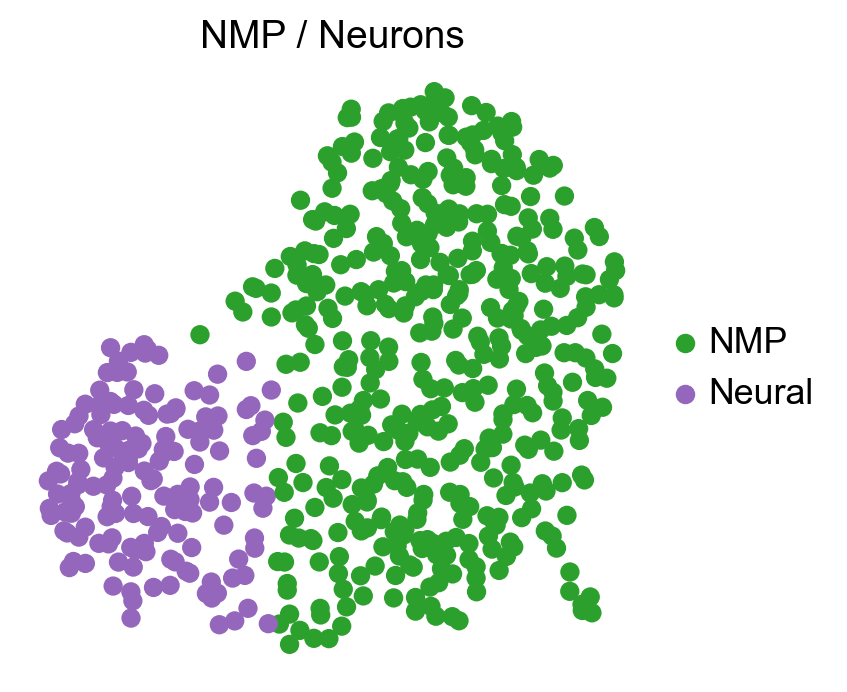

In [36]:
sc.pl.umap(adata_sc, color=['leiden_sc'], title='NMP / Neurons', palette=['tab:green', 'tab:purple'])

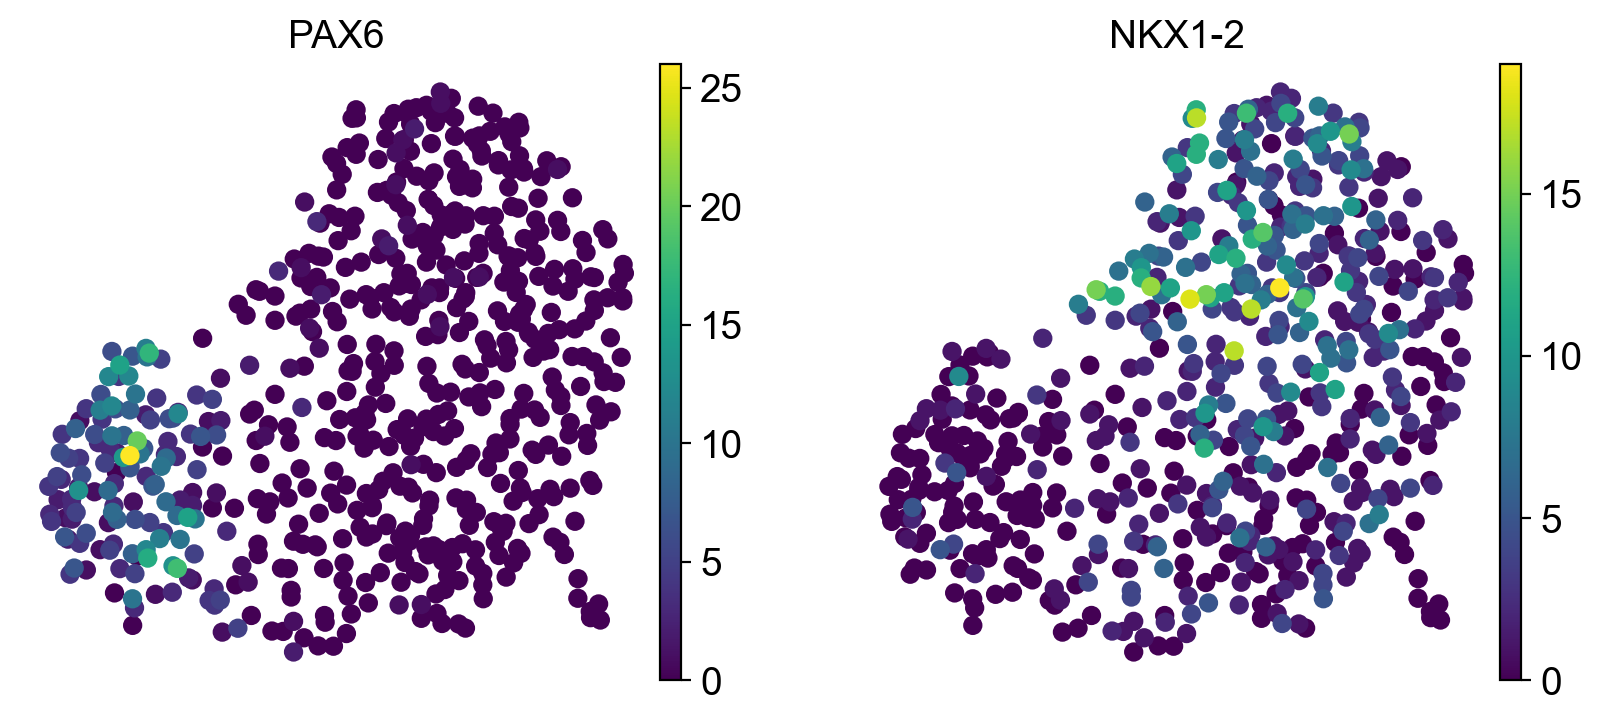

In [42]:
sc.pl.umap(adata_sc, color=['PAX6', 'NKX1-2'], color_map='viridis')

## Reinjection

In [43]:
obs = adata_sc.obs_names.to_list()

In [44]:
tmp=adata[~adata.obs_names.isin(obs),:]
adata_bis = sc.AnnData(tmp.raw.X,obs=tmp.obs,var=tmp.raw.var)

In [45]:
tmp_2=adata_sc
adata_sc2 = sc.AnnData(tmp_2.raw.X,obs=tmp_2.obs,var=tmp_2.raw.var)
adata_sc2.obs['leiden']=adata_sc2.obs['leiden_sc']

In [46]:
adata_injected = adata_sc2.concatenate(adata_bis, batch_key='batch_layer_2')

## Identical preprocess

In [47]:
cell_cycle_genes = [x.strip() for x in open('utils/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

In [48]:
adata_injected.raw = adata_injected

In [49]:
sc.pp.normalize_total(adata_injected)

In [50]:
sc.pp.log1p(adata_injected)

In [51]:
sc.pp.highly_variable_genes(adata_injected, n_top_genes=1500)

In [52]:
sc.pp.regress_out(adata_injected, ['S_score', 'G2M_score'], n_jobs = 16)

... storing 'leiden' as categorical


In [53]:
sc.pp.scale(adata_injected)

In [54]:
sc.tl.pca(adata_injected, n_comps=50)

In [55]:
sce.pp.bbknn(adata_injected, batch_key='timepoint', local_connectivity=6)

In [56]:
sc.tl.umap(adata_injected)

In [21]:
sc.pl.umap(adata_injected, color=['leiden'], title='Segmentoid', palette=['tab:green', 'tab:purple', 'tab:blue', 'tab:cyan', 'tab:red', 'tab:gray'])

NameError: name 'adata_injected' is not defined

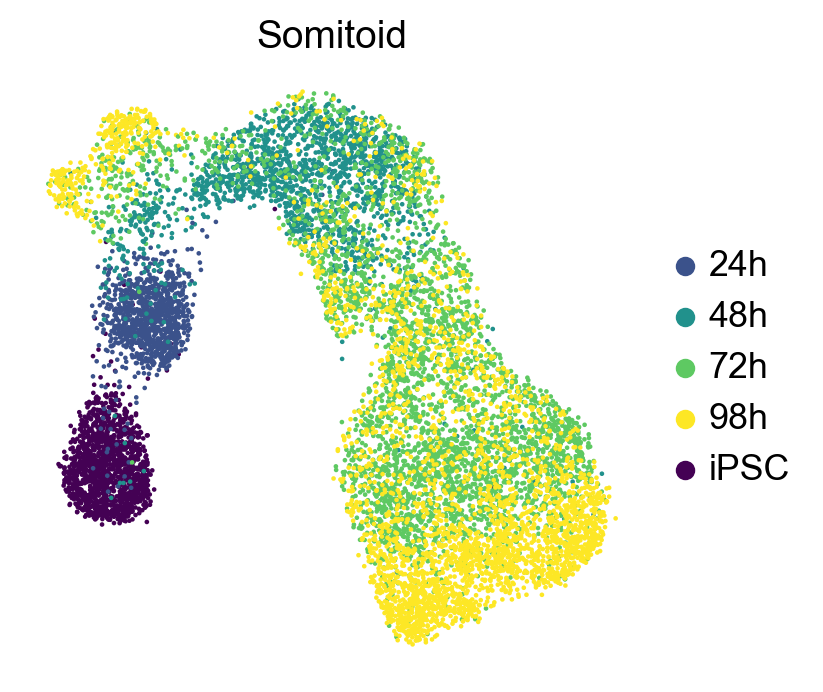

In [67]:
sc.pl.umap(adata_injected, color=['timepoint'], title='Segmentoid', palette=['#3b528b', '#21918c', '#5ec962', '#fde725', '#440154'])

## Gene expression

In [59]:
sc.tl.rank_genes_groups(adata_injected, groupby='leiden', use_raw=True, method='wilcoxon', corr_method='benjamini-hochberg')
pd.DataFrame(adata_injected.uns['rank_genes_groups']['names']).iloc[0:20,:]

,NMP,Neural,PSM Ant,PSM Post,Somite,iPSC
0,TUBB2A,CDH6,FOXC2,MSGN1,IGFBP5,TERF1
1,TUBB2B,PAX6,SLC5A3,TBX6,NR2F2,CD24
2,WNT5B,SOX2,MRPS6,RSPO3,SEPTIN11,TDGF1
3,CNTNAP2,IGFBP2,SSTR2,DLL3,NR2F1,MIR302CHG
4,SLC2A3,CA4,MEST,HES7,BOC,FOXD3-AS1
5,KRT18,CRABP2,LEF1,NTS,COL2A1,LINC00678
6,NKX1-2,PRSS23,PFN2,SMC6,ALCAM,UGP2
7,SERPINE2,TTYH1,FABP5,APLNR,TCF15,USP44
8,SLC3A2,PPP1R1A,CXCR4,ARL4D,SIX1,L1TD1
9,GSTO1,METRN,CALD1,PLXNA2,PAX3,RARRES2


In [60]:
order_dotplot = ['iPSC', 'NMP', 'Neural', 'PSM Post', 'PSM Ant', 'Somite']

In [61]:
markers = ['SOX2', 'POU5F1', 'NKX1-2', 'TBXT', 'PAX6', 'HES7', 'MSGN1', 'TBX6', 'DLL1', 'RIPPLY2', 'MEOX1', 'MESP2', 'TCF15', 
          'MYOCD', 'UNCX', 'TBX18', 'PAX3']

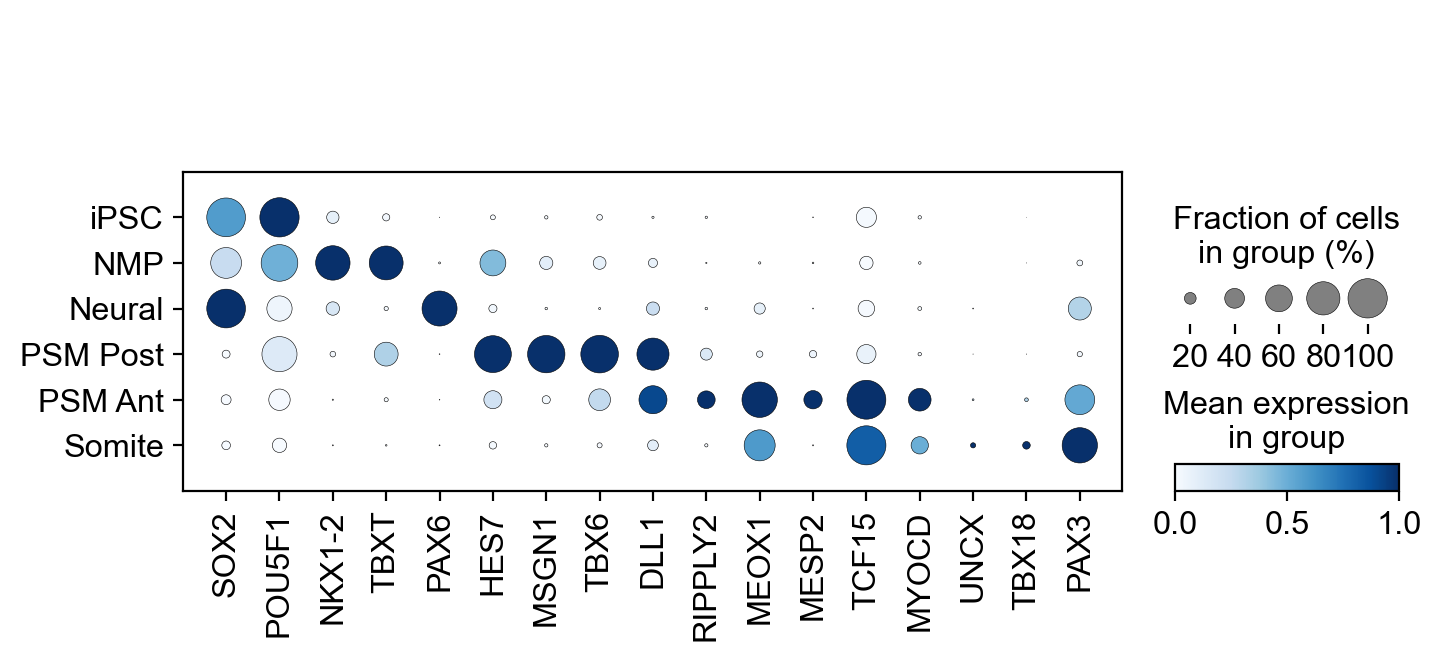

In [62]:
sc.pl.dotplot(adata_injected, markers, 'leiden', categories_order=order_dotplot, return_fig=False,color_map='Blues', standard_scale='var')

## TBX18 / UNCX

In [51]:
adata_df = pd.DataFrame(adata_injected.raw.X.toarray(), index = adata_injected.obs.index, columns = adata_injected.raw.var.index)
index_TBX18 = adata_df[adata_df.TBX18 > 0].index 
adata_TBX18 = adata_injected[adata_injected.obs.index.isin(index_TBX18)]
adata_TBX18.obs['gene_subset'] = 'TBX18'
print('TBX18+ cells : ' + str(adata_TBX18.shape[0]))

Trying to set attribute `.obs` of view, copying.


TBX18+ cells : 535


In [52]:
adata_df = pd.DataFrame(adata_injected.raw.X.toarray(), index = adata_injected.obs.index, columns = adata_injected.raw.var.index)
index_UNCX = adata_df[adata_df.UNCX > 0].index 
adata_UNCX = adata_injected[adata_injected.obs.index.isin(index_UNCX)]
adata_UNCX.obs['gene_subset'] = 'UNCX'
print('UNCX+ cells : ' + str(adata_UNCX.shape[0]))

Trying to set attribute `.obs` of view, copying.


UNCX+ cells : 312


In [53]:
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))
print('TBX18+ and UNCX+ cells : ' + str(len(intersection(adata_TBX18.obs_names.to_list(), adata_UNCX.obs_names.to_list()))))

TBX18+ and UNCX+ cells : 9


## Segmentoid model proportion

In [4]:
ipsc = adata_injected[adata_injected.obs['leiden'].isin(['iPSC']),:]
ipsc.obs['clusters']=ipsc.obs['leiden']
ipsc.obs['timepoint']='iPSC'
segmentoid_24h = sc.read('data/sample_1_segmentoid_24h_velo_processed.h5ad')
segmentoid_48h = sc.read('data/sample_1_segmentoid_48h_velo_processed.h5ad')
segmentoid_72h = sc.read('data/sample_1_segmentoid_72h_velo_processed.h5ad')
segmentoid_98h = sc.read('data/sample_1_segmentoid_98h_velo_processed.h5ad')
adata_segmentoid_independant = segmentoid_24h.concatenate(ipsc,segmentoid_48h,segmentoid_72h,segmentoid_98h)

Trying to set attribute `.obs` of view, copying.


In [5]:
cluster_key="clusters"
sample_key="timepoint"
adata_tmp = adata_segmentoid_independant.copy()
sizes = adata_tmp.obs.groupby([cluster_key, sample_key]).size()
cluster_props = sizes.groupby(level=1).apply(lambda x: x).reset_index()
cluster_props = cluster_props.pivot(columns=sample_key, index=cluster_key).T
cluster_props.index = cluster_props.index.droplevel(0)
cluster_props.fillna(0, inplace=True)
cluster_props = cluster_props.round(decimals=1)
cluster_props

clusters,NMP,Neural,PSM,Somite,iPSC
timepoint,,,,,
24h,944.0,0.0,122.0,0.0,0.0
48h,230.0,0.0,1347.0,0.0,0.0
72h,224.0,50.0,838.0,2427.0,0.0
98h,201.0,128.0,322.0,2537.0,0.0
iPSC,0.0,0.0,0.0,0.0,1514.0


In [6]:
cluster_props = cluster_props.reindex( ['iPSC', '24h', '48h', '72h', '98h'])

In [7]:
cluster_props

clusters,NMP,Neural,PSM,Somite,iPSC
timepoint,,,,,
iPSC,0.0,0.0,0.0,0.0,1514.0
24h,944.0,0.0,122.0,0.0,0.0
48h,230.0,0.0,1347.0,0.0,0.0
72h,224.0,50.0,838.0,2427.0,0.0
98h,201.0,128.0,322.0,2537.0,0.0


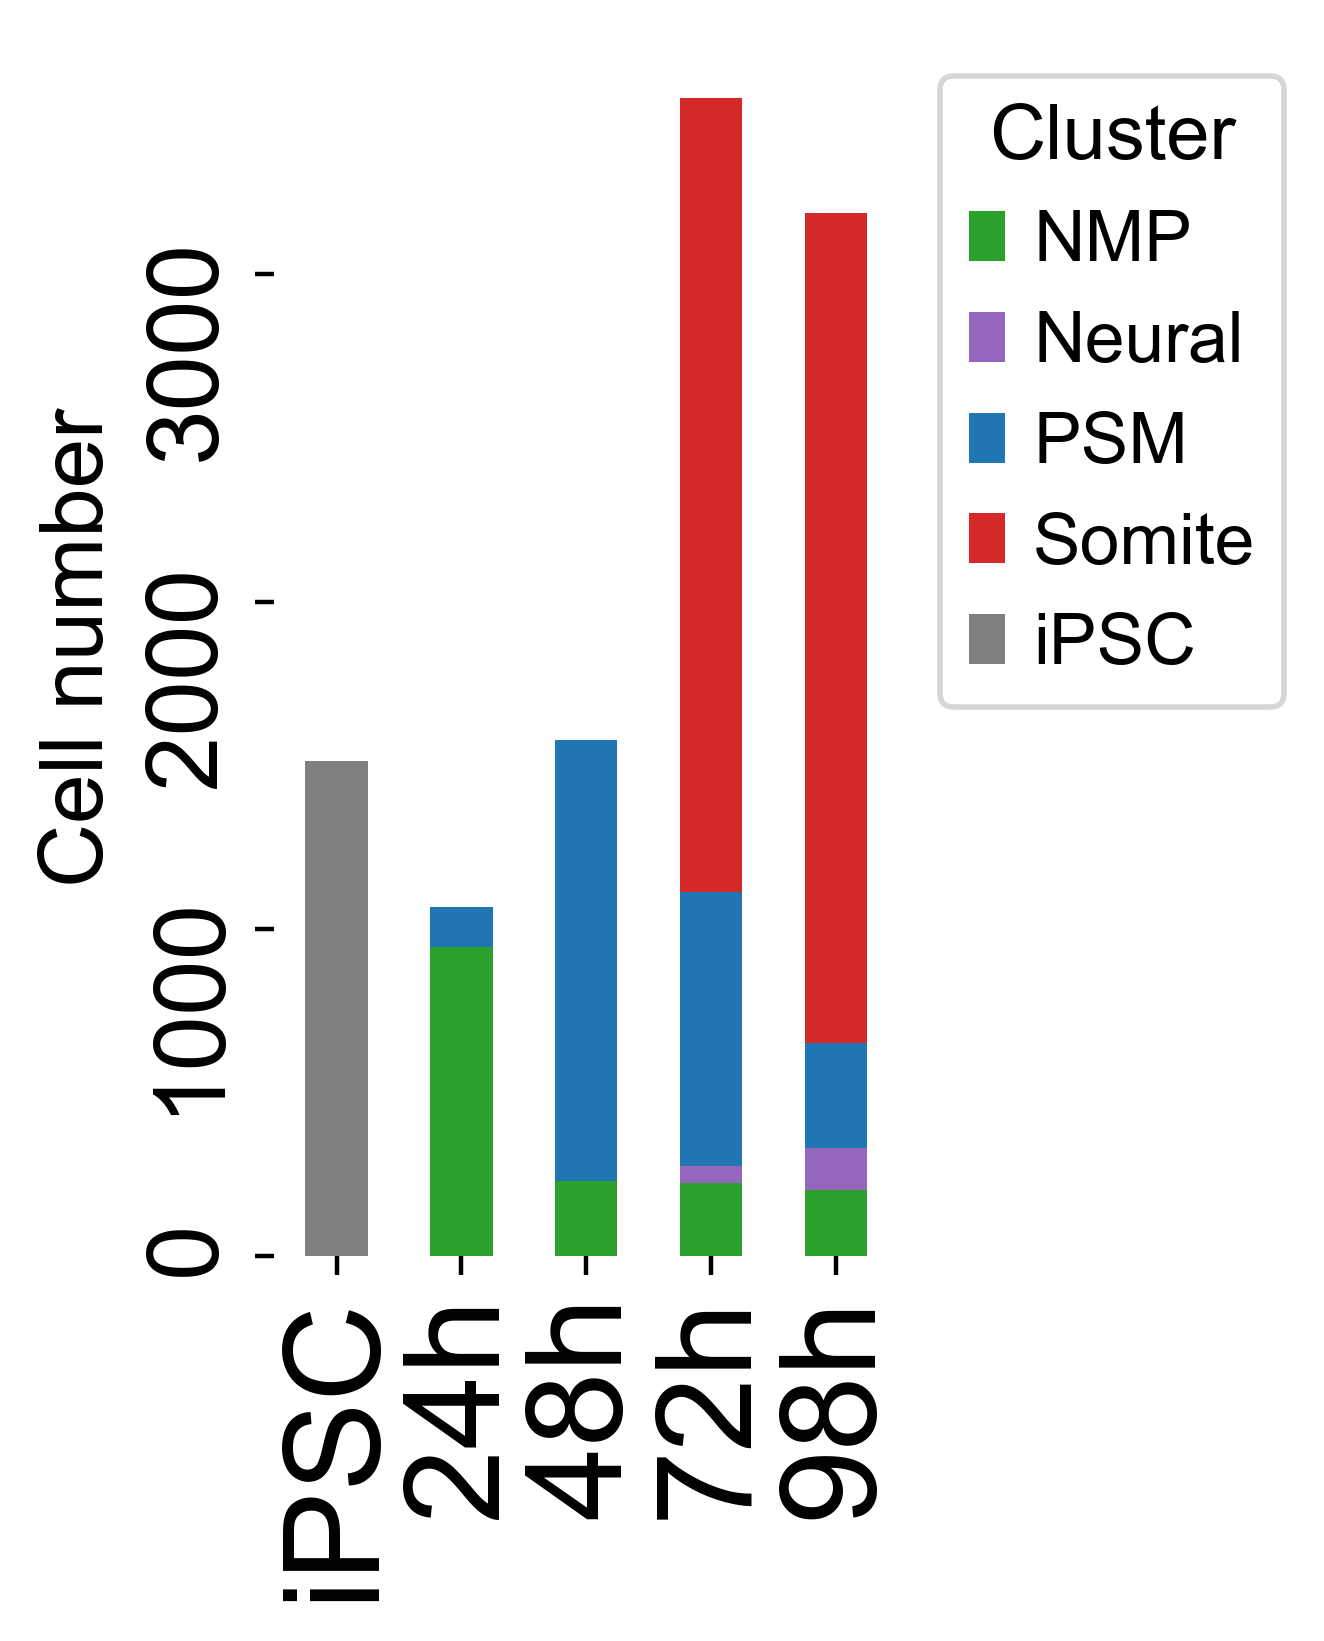

In [9]:
cluster_palette=['tab:green', 'tab:purple', 'tab:blue', 'tab:red', 'tab:gray']
xlabel_rotation=90
taillepolice=18

fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor("white")

cmap = None
if cluster_palette is not None:
    cmap = sns.palettes.blend_palette(
        cluster_palette, 
        n_colors=len(cluster_palette), 
        as_cmap=True)

cluster_props.plot(
    kind="bar",
    stacked=True, 
    ax=ax, 
    legend=False,
    colormap=cmap,
    fontsize='xx-large'
)

ax.legend(bbox_to_anchor=(1.01, 1), frameon=True, title="Cluster")
sns.despine(fig, ax, left=True, bottom=True)
ax.tick_params(axis="y", rotation=xlabel_rotation, labelsize=taillepolice)
ax.set_xlabel('')
ax.set_ylabel("Cell number", fontsize=16)
ax.yaxis.set_label_position("left")
ax.yaxis.tick_left()
fig.set_size_inches(2,4)
plt.yticks(rotation = 90)
ax.grid(False)
plt.savefig('figures/bargraph.pdf',bbox_inches='tight')

## Save

In [ ]:
adata_injected.write('data/segmentoid_processed.h5ad')